In [35]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from statsmodels.stats.stattools import jarque_bera

### Loading Data

In [36]:
stock_df = pd.read_csv('stock.csv')
symbols = ['AAPL', 'ME']

In [37]:
# Convert date to datetime format
stock_df['date'] = pd.to_datetime(stock_df['date'])

# 1. Change META ticker with "LISTED FUNDS TRUST" to METV
#    This separates the ETF that temporarily used META ticker
stock_df.loc[
    (stock_df['TSYMBOL'] == 'META') &
    (stock_df['COMNAM'] == 'LISTED FUNDS TRUST'),
    'TSYMBOL'
] = 'METV'

# 2. Merge FB into META
#    Facebook Inc (FB) was renamed to Meta Platforms Inc (META) in June 2022
stock_df.loc[stock_df['TSYMBOL'] == 'FB', 'TSYMBOL'] = 'META'

# 3. Convert RET to numeric, replacing non-numeric values with NaN
#    Some RET values are strings like 'C' or 'A', which need to be handled
stock_df['RET'] = pd.to_numeric(stock_df['RET'], errors='coerce')

# 4. Sort by date and ticker
stock_df = stock_df.sort_values(['date', 'TSYMBOL'])

# 5. Verify the results
print("=== Data Cleaning Complete ===")
print(f"Total observations: {len(stock_df)}")
print("\nData count by ticker:")
print(stock_df['TSYMBOL'].value_counts().sort_index())
print(f"\nNon-numeric RET values converted to NaN: {stock_df['RET'].isna().sum()}")

=== Data Cleaning Complete ===
Total observations: 11452

Data count by ticker:
TSYMBOL
AAPL     1510
AMZN     1510
GOOGL    1510
META     1510
METV      882
MSFT     1510
NVDA     1510
TSLA     1510
Name: count, dtype: int64

Non-numeric RET values converted to NaN: 1


In [38]:
"""
    PRC is the variable name for price
"""

stock_df['date'] = pd.to_datetime(stock_df['date'])
stock_df = stock_df.sort_values(['date','TSYMBOL'])

prices = stock_df.pivot(index='date',
                        columns='TSYMBOL',
                        values='PRC')

prices.head()

TSYMBOL,AAPL,AMZN,GOOGL,META,METV,MSFT,NVDA,TSLA
date,,,,,,,,
2019-01-02,157.92000,1539.13000,1054.68005,135.67999,NaN,101.12,136.22000,310.12000
2019-01-03,142.19000,1500.28003,1025.46997,131.74001,NaN,97.40,127.99000,300.35999
2019-01-04,148.25999,1575.39001,1078.06995,137.95000,NaN,101.93,136.19000,317.69000
2019-01-07,147.92999,1629.51001,1075.92004,138.05000,NaN,102.06,143.39999,334.95999
2019-01-08,150.75000,1656.57996,1085.37000,142.53000,NaN,102.80,139.83000,335.35001


In [39]:
"""
    RET is the variable name for returns
"""

stock_df['date'] = pd.to_datetime(stock_df['date'])
stock_df = stock_df.sort_values(['date','TSYMBOL'])

# pivot into wide form: rows = dates, cols = tickers, values = price
returns = stock_df.pivot(index='date',
                        columns='TSYMBOL',
                        values='RET')

returns.head()

TSYMBOL,AAPL,AMZN,GOOGL,META,METV,MSFT,NVDA,TSLA
date,,,,,,,,
2019-01-02,0.001141,0.024741,0.009302,0.035014,NaN,-0.004430,0.020375,-0.068149
2019-01-03,-0.099607,-0.025242,-0.027696,-0.029039,NaN,-0.036788,-0.060417,-0.031472
2019-01-04,0.042689,0.050064,0.051294,0.047138,NaN,0.046509,0.064068,0.057697
2019-01-07,-0.002226,0.034353,-0.001994,0.000725,NaN,0.001275,0.052941,0.054361
2019-01-08,0.019063,0.016612,0.008783,0.032452,NaN,0.007251,-0.024895,0.001164


In [40]:
print("=" * 80)
print("Data Validation: Final Check Before Normality Analysis")
print("=" * 80)

# 1. Basic Information
print("\n[1] Basic Information")
print(f"- Total number of dates: {len(returns)}")
print(f"- Date range: {returns.index.min()} to {returns.index.max()}")
print(f"- Number of tickers: {len(returns.columns)}")
print(f"- Ticker list: {returns.columns.tolist()}")

# 2. Data summary and missing values by ticker
print("\n[2] Data Summary by Ticker")
print("-" * 60)
print(f"{'Ticker':<10} {'Total Data':<15} {'Missing':<10} {'Valid Data':<15} {'Data Ratio'}")
print("-" * 60)
for ticker in returns.columns:
    total = len(returns)
    missing = returns[ticker].isnull().sum()
    valid = total - missing
    ratio = (valid / total) * 100
    print(f"{ticker:<10} {total:<15} {missing:<10} {valid:<15} {ratio:.1f}%")

# 3. Actual trading period for each ticker
print("\n[3] Trading Period by Ticker")
print("-" * 60)
for ticker in returns.columns:
    data = returns[ticker].dropna()
    if len(data) > 0:
        print(f"{ticker:<10} {data.index.min()} to {data.index.max()} ({len(data)} obs)")
    else:
        print(f"{ticker:<10} No data available")

# 4. Detailed verification of merged tickers
print("\n[4] Merged Tickers Detailed Verification")
print("-" * 60)

# META (FB + Meta Platforms)
print("\n▶ META (Facebook → Meta Platforms)")
meta_original = stock_df[stock_df['TSYMBOL'] == 'META'].sort_values('date')
fb_period = meta_original[meta_original['COMNAM'] == 'FACEBOOK INC']
meta_period = meta_original[meta_original['COMNAM'] == 'META PLATFORMS INC']
print(f"  - Facebook Inc period: {fb_period['date'].min()} to {fb_period['date'].max()} ({len(fb_period)} obs)")
print(f"  - Meta Platforms period: {meta_period['date'].min()} to {meta_period['date'].max()} ({len(meta_period)} obs)")
print(f"  - Total after merge: {len(meta_original)} observations")

# METV (Listed Funds Trust ETF)
print("\n▶ METV (Listed Funds Trust ETF)")
metv_original = stock_df[stock_df['TSYMBOL'] == 'METV'].sort_values('date')
metv_with_meta_ticker = metv_original[metv_original['TICKER'] == 'META']
metv_with_metv_ticker = metv_original[metv_original['TICKER'] == 'METV']
if len(metv_with_meta_ticker) > 0:
    print(f"  - Period with META ticker: {metv_with_meta_ticker['date'].min()} to {metv_with_meta_ticker['date'].max()} ({len(metv_with_meta_ticker)} obs)")
if len(metv_with_metv_ticker) > 0:
    print(f"  - Period after ticker change to METV: {metv_with_metv_ticker['date'].min()} to {metv_with_metv_ticker['date'].max()} ({len(metv_with_metv_ticker)} obs)")
print(f"  - Total after merge: {len(metv_original)} observations")

# 5. Basic statistics of returns
print("\n[5] Returns Basic Statistics")
print("-" * 60)
print(returns.describe())

# 6. Extreme returns check (outliers) - FIXED VERSION
print("\n[6] Extreme Returns Check (|return| > 0.2, i.e., ±20%)")
print("-" * 60)
found_extreme = False
for ticker in returns.columns:
    # Ensure we're working with numeric data only
    ticker_data = pd.to_numeric(returns[ticker], errors='coerce')
    extreme = ticker_data[ticker_data.abs() > 0.2].dropna()
    if len(extreme) > 0:
        found_extreme = True
        print(f"\n{ticker}: {len(extreme)} extreme returns found")
        print(extreme.sort_values(ascending=False).head(3))

if not found_extreme:
    print("No extreme returns (>20%) found in any ticker.")

# 7. Missing data pattern summary
print("\n[7] Missing Data Pattern Summary")
print("-" * 60)
missing_by_ticker = returns.isnull().sum()
if missing_by_ticker.sum() > 0:
    print("Tickers with missing values:")
    for ticker in missing_by_ticker[missing_by_ticker > 0].index:
        pct = (missing_by_ticker[ticker] / len(returns)) * 100
        print(f"  - {ticker}: {missing_by_ticker[ticker]} missing ({pct:.1f}%)")
else:
    print("No missing values in any ticker.")

# 8. Final confirmation message
print("\n" + "=" * 80)
print("✅ Data Validation Complete")
print("=" * 80)
print("\nNext Step: Begin Normality Analysis")
print("  - 8 tickers to be analyzed")
print("  - METV will be analyzed only for its valid period due to missing data")
print("\n")

Data Validation: Final Check Before Normality Analysis

[1] Basic Information
- Total number of dates: 1510
- Date range: 2019-01-02 00:00:00 to 2024-12-31 00:00:00
- Number of tickers: 8
- Ticker list: ['AAPL', 'AMZN', 'GOOGL', 'META', 'METV', 'MSFT', 'NVDA', 'TSLA']

[2] Data Summary by Ticker
------------------------------------------------------------
Ticker     Total Data      Missing    Valid Data      Data Ratio
------------------------------------------------------------
AAPL       1510            0          1510            100.0%
AMZN       1510            0          1510            100.0%
GOOGL      1510            0          1510            100.0%
META       1510            0          1510            100.0%
METV       1510            629        881             58.3%
MSFT       1510            0          1510            100.0%
NVDA       1510            0          1510            100.0%
TSLA       1510            0          1510            100.0%

[3] Trading Period by Ticker

# 📈 **PART 1**

## 1.1 Table of Normality Test

In [41]:
normality_results = {}

In [42]:
# normality for AAPL

# Header
print("=" * 80)
print("AAPL - Normality Tests")
print("=" * 80)

# Before Test
aapl_returns = returns['AAPL'].dropna()
print(f"\nSample size: {len(aapl_returns)} observations")


# Test 1: Shapiro-Wilk Test
print("\n[1] Shapiro-Wilk Test")
shapiro_stat, shapiro_pval = stats.shapiro(aapl_returns)
print(f"    Test statistic: {shapiro_stat:.4f}")
print(f"    P-value: {shapiro_pval:.4e}")


# Test 2: D'Agostino-Pearson K² Test
print("\n[2] D'Agostino-Pearson K² Test")
dagostino_stat, dagostino_pval = stats.normaltest(aapl_returns)
print(f"    Test statistic: {dagostino_stat:.4f}")
print(f"    P-value: {dagostino_pval:.4e}")


# Test 3: Jarque-Bera Test
print("\n[3] Jarque-Bera Test")
jb_stat, jb_pval, jb_skew, jb_kurt = jarque_bera(aapl_returns)
print(f"    Test statistic: {jb_stat:.4f}")
print(f"    P-value: {jb_pval:.4e}")


print("=" * 80)

normality_results['AAPL'] = {
    'n': len(aapl_returns),
    'shapiro': (shapiro_stat, shapiro_pval),
    'dagostino': (dagostino_stat, dagostino_pval),
    'jarque_bera': (jb_stat, jb_pval)
}

AAPL - Normality Tests

Sample size: 1510 observations

[1] Shapiro-Wilk Test
    Test statistic: 0.9396
    P-value: 2.5671e-24

[2] D'Agostino-Pearson K² Test
    Test statistic: 186.1488
    P-value: 3.7870e-41

[3] Jarque-Bera Test
    Test statistic: 1900.4194
    P-value: 0.0000e+00


In [43]:
# normality for AMZN

# Header
print("=" * 80)
print("AMZN - Normality Tests")
print("=" * 80)

# Before Test
amzn_returns = returns['AMZN'].dropna()
print(f"\nSample size: {len(amzn_returns)} observations")


# Test 1: Shapiro-Wilk Test
print("\n[1] Shapiro-Wilk Test")
shapiro_stat, shapiro_pval = stats.shapiro(amzn_returns)
print(f"    Test statistic: {shapiro_stat:.4f}")
print(f"    P-value: {shapiro_pval:.4e}")


# Test 2: D'Agostino-Pearson K² Test
print("\n[2] D'Agostino-Pearson K² Test")
dagostino_stat, dagostino_pval = stats.normaltest(amzn_returns)
print(f"    Test statistic: {dagostino_stat:.4f}")
print(f"    P-value: {dagostino_pval:.4e}")


# Test 3: Jarque-Bera Test
print("\n[3] Jarque-Bera Test")
jb_stat, jb_pval, jb_skew, jb_kurt = jarque_bera(amzn_returns)
print(f"    Test statistic: {jb_stat:.4f}")
print(f"    P-value: {jb_pval:.4e}")


print("=" * 80)

normality_results['AMZN'] = {
    'n': len(amzn_returns),
    'shapiro': (shapiro_stat, shapiro_pval),
    'dagostino': (dagostino_stat, dagostino_pval),
    'jarque_bera': (jb_stat, jb_pval)
}

AMZN - Normality Tests

Sample size: 1510 observations

[1] Shapiro-Wilk Test
    Test statistic: 0.9567
    P-value: 9.3692e-21

[2] D'Agostino-Pearson K² Test
    Test statistic: 155.1573
    P-value: 2.0324e-34

[3] Jarque-Bera Test
    Test statistic: 1173.7180
    P-value: 1.3501e-255


In [44]:
# normality for GOOGL

# Header
print("=" * 80)
print("GOOGL - Normality Tests")
print("=" * 80)

# Before Test
googl_returns = returns['GOOGL'].dropna()
print(f"\nSample size: {len(googl_returns)} observations")


# Test 1: Shapiro-Wilk Test
print("\n[1] Shapiro-Wilk Test")
shapiro_stat, shapiro_pval = stats.shapiro(googl_returns)
print(f"    Test statistic: {shapiro_stat:.4f}")
print(f"    P-value: {shapiro_pval:.4e}")


# Test 2: D'Agostino-Pearson K² Test
print("\n[2] D'Agostino-Pearson K² Test")
dagostino_stat, dagostino_pval = stats.normaltest(googl_returns)
print(f"    Test statistic: {dagostino_stat:.4f}")
print(f"    P-value: {dagostino_pval:.4e}")


# Test 3: Jarque-Bera Test
print("\n[3] Jarque-Bera Test")
jb_stat, jb_pval, jb_skew, jb_kurt = jarque_bera(googl_returns)
print(f"    Test statistic: {jb_stat:.4f}")
print(f"    P-value: {jb_pval:.4e}")


print("=" * 80)

normality_results['GOOGL'] = {
    'n': len(googl_returns),
    'shapiro': (shapiro_stat, shapiro_pval),
    'dagostino': (dagostino_stat, dagostino_pval),
    'jarque_bera': (jb_stat, jb_pval)
}


GOOGL - Normality Tests

Sample size: 1510 observations

[1] Shapiro-Wilk Test
    Test statistic: 0.9483
    P-value: 1.2806e-22

[2] D'Agostino-Pearson K² Test
    Test statistic: 148.5085
    P-value: 5.6466e-33

[3] Jarque-Bera Test
    Test statistic: 1068.5480
    P-value: 9.2845e-233


In [45]:
# normality for META

# Header
print("=" * 80)
print("META - Normality Tests")
print("=" * 80)

# Before Test
meta_returns = returns['META'].dropna()
print(f"\nSample size: {len(meta_returns)} observations")


# Test 1: Shapiro-Wilk Test
print("\n[1] Shapiro-Wilk Test")
shapiro_stat, shapiro_pval = stats.shapiro(meta_returns)
print(f"    Test statistic: {shapiro_stat:.4f}")
print(f"    P-value: {shapiro_pval:.4e}")


# Test 2: D'Agostino-Pearson K² Test
print("\n[2] D'Agostino-Pearson K² Test")
dagostino_stat, dagostino_pval = stats.normaltest(meta_returns)
print(f"    Test statistic: {dagostino_stat:.4f}")
print(f"    P-value: {dagostino_pval:.4e}")


# Test 3: Jarque-Bera Test
print("\n[3] Jarque-Bera Test")
jb_stat, jb_pval, jb_skew, jb_kurt = jarque_bera(meta_returns)
print(f"    Test statistic: {jb_stat:.4f}")
print(f"    P-value: {jb_pval:.4e}")


print("=" * 80)

normality_results['META'] = {
    'n': len(meta_returns),
    'shapiro': (shapiro_stat, shapiro_pval),
    'dagostino': (dagostino_stat, dagostino_pval),
    'jarque_bera': (jb_stat, jb_pval)
}


META - Normality Tests

Sample size: 1510 observations

[1] Shapiro-Wilk Test
    Test statistic: 0.8612
    P-value: 1.5021e-34

[2] D'Agostino-Pearson K² Test
    Test statistic: 394.6418
    P-value: 2.0166e-86

[3] Jarque-Bera Test
    Test statistic: 22810.3783
    P-value: 0.0000e+00


In [46]:
# normality for METV

# Header
print("=" * 80)
print("METV - Normality Tests")
print("=" * 80)

# Before Test
metv_returns = returns['METV'].dropna()
print(f"\nSample size: {len(metv_returns)} observations")


# Test 1: Shapiro-Wilk Test
print("\n[1] Shapiro-Wilk Test")
shapiro_stat, shapiro_pval = stats.shapiro(metv_returns)
print(f"    Test statistic: {shapiro_stat:.4f}")
print(f"    P-value: {shapiro_pval:.4e}")


# Test 2: D'Agostino-Pearson K² Test
print("\n[2] D'Agostino-Pearson K² Test")
dagostino_stat, dagostino_pval = stats.normaltest(metv_returns)
print(f"    Test statistic: {dagostino_stat:.4f}")
print(f"    P-value: {dagostino_pval:.4e}")


# Test 3: Jarque-Bera Test
print("\n[3] Jarque-Bera Test")
jb_stat, jb_pval, jb_skew, jb_kurt = jarque_bera(metv_returns)
print(f"    Test statistic: {jb_stat:.4f}")
print(f"    P-value: {jb_pval:.4e}")


print("=" * 80)

normality_results['METV'] = {
    'n': len(metv_returns),
    'shapiro': (shapiro_stat, shapiro_pval),
    'dagostino': (dagostino_stat, dagostino_pval),
    'jarque_bera': (jb_stat, jb_pval)
}

METV - Normality Tests

Sample size: 881 observations

[1] Shapiro-Wilk Test
    Test statistic: 0.9852
    P-value: 8.7800e-08

[2] D'Agostino-Pearson K² Test
    Test statistic: 28.3377
    P-value: 7.0233e-07

[3] Jarque-Bera Test
    Test statistic: 68.9124
    P-value: 1.0861e-15


In [47]:
# normality for MSFT

# Header
print("=" * 80)
print("MSFT - Normality Tests")
print("=" * 80)

# Before Test
msft_returns = returns['MSFT'].dropna()
print(f"\nSample size: {len(msft_returns)} observations")


# Test 1: Shapiro-Wilk Test
print("\n[1] Shapiro-Wilk Test")
shapiro_stat, shapiro_pval = stats.shapiro(msft_returns)
print(f"    Test statistic: {shapiro_stat:.4f}")
print(f"    P-value: {shapiro_pval:.4e}")


# Test 2: D'Agostino-Pearson K² Test
print("\n[2] D'Agostino-Pearson K² Test")
dagostino_stat, dagostino_pval = stats.normaltest(msft_returns)
print(f"    Test statistic: {dagostino_stat:.4f}")
print(f"    P-value: {dagostino_pval:.4e}")


# Test 3: Jarque-Bera Test
print("\n[3] Jarque-Bera Test")
jb_stat, jb_pval, jb_skew, jb_kurt = jarque_bera(msft_returns)
print(f"    Test statistic: {jb_stat:.4f}")
print(f"    P-value: {jb_pval:.4e}")


print("=" * 80)

normality_results['MSFT'] = {
    'n': len(msft_returns),
    'shapiro': (shapiro_stat, shapiro_pval),
    'dagostino': (dagostino_stat, dagostino_pval),
    'jarque_bera': (jb_stat, jb_pval)
}


MSFT - Normality Tests

Sample size: 1510 observations

[1] Shapiro-Wilk Test
    Test statistic: 0.9348
    P-value: 3.5118e-25

[2] D'Agostino-Pearson K² Test
    Test statistic: 229.9468
    P-value: 1.1687e-50

[3] Jarque-Bera Test
    Test statistic: 3477.3669
    P-value: 0.0000e+00


In [48]:
# normality for NVDA

# Header
print("=" * 80)
print("NVDA - Normality Tests")
print("=" * 80)

# Before Test
nvda_returns = returns['NVDA'].dropna()
print(f"\nSample size: {len(nvda_returns)} observations")


# Test 1: Shapiro-Wilk Test
print("\n[1] Shapiro-Wilk Test")
shapiro_stat, shapiro_pval = stats.shapiro(nvda_returns)
print(f"    Test statistic: {shapiro_stat:.4f}")
print(f"    P-value: {shapiro_pval:.4e}")


# Test 2: D'Agostino-Pearson K² Test
print("\n[2] D'Agostino-Pearson K² Test")
dagostino_stat, dagostino_pval = stats.normaltest(nvda_returns)
print(f"    Test statistic: {dagostino_stat:.4f}")
print(f"    P-value: {dagostino_pval:.4e}")


# Test 3: Jarque-Bera Test
print("\n[3] Jarque-Bera Test")
jb_stat, jb_pval, jb_skew, jb_kurt = jarque_bera(nvda_returns)
print(f"    Test statistic: {jb_stat:.4f}")
print(f"    P-value: {jb_pval:.4e}")


print("=" * 80)

normality_results['NVDA'] = {
    'n': len(nvda_returns),
    'shapiro': (shapiro_stat, shapiro_pval),
    'dagostino': (dagostino_stat, dagostino_pval),
    'jarque_bera': (jb_stat, jb_pval)
}

NVDA - Normality Tests

Sample size: 1510 observations

[1] Shapiro-Wilk Test
    Test statistic: 0.9648
    P-value: 1.1093e-18

[2] D'Agostino-Pearson K² Test
    Test statistic: 180.6396
    P-value: 5.9514e-40

[3] Jarque-Bera Test
    Test statistic: 1134.7336
    P-value: 3.9422e-247


In [49]:
# normality for TSLA

# Header
print("=" * 80)
print("TSLA - Normality Tests")
print("=" * 80)

# Before Test
tsla_returns = returns['TSLA'].dropna()
print(f"\nSample size: {len(tsla_returns)} observations")


# Test 1: Shapiro-Wilk Test
print("\n[1] Shapiro-Wilk Test")
shapiro_stat, shapiro_pval = stats.shapiro(tsla_returns)
print(f"    Test statistic: {shapiro_stat:.4f}")
print(f"    P-value: {shapiro_pval:.4e}")


# Test 2: D'Agostino-Pearson K² Test
print("\n[2] D'Agostino-Pearson K² Test")
dagostino_stat, dagostino_pval = stats.normaltest(tsla_returns)
print(f"    Test statistic: {dagostino_stat:.4f}")
print(f"    P-value: {dagostino_pval:.4e}")


# Test 3: Jarque-Bera Test
print("\n[3] Jarque-Bera Test")
jb_stat, jb_pval, jb_skew, jb_kurt = jarque_bera(tsla_returns)
print(f"    Test statistic: {jb_stat:.4f}")
print(f"    P-value: {jb_pval:.4e}")


print("=" * 80)

normality_results['TSLA'] = {
    'n': len(tsla_returns),
    'shapiro': (shapiro_stat, shapiro_pval),
    'dagostino': (dagostino_stat, dagostino_pval),
    'jarque_bera': (jb_stat, jb_pval)
}

TSLA - Normality Tests

Sample size: 1510 observations

[1] Shapiro-Wilk Test
    Test statistic: 0.9562
    P-value: 7.0392e-21

[2] D'Agostino-Pearson K² Test
    Test statistic: 138.5270
    P-value: 8.3031e-31

[3] Jarque-Bera Test
    Test statistic: 777.6221
    P-value: 1.3852e-169


In [50]:
# Table: Normality Test Results

print("=" * 100)
print("Summary Table: Normality Test Results for Each Stock")
print("=" * 100)

# Use stored results (no recalculation!)
for ticker in ['AAPL', 'AMZN', 'GOOGL', 'META', 'METV', 'MSFT', 'NVDA', 'TSLA']:
    result = normality_results[ticker]

    print(f"\n{'='*100}")
    print(f"{ticker} - Normality Test Results (n = {result['n']})")
    print(f"{'='*100}")
    print(f"{'Test Name':<30} {'Test Statistic':<20} {'P-value':<20}")
    print("-" * 100)
    print(f"{'Shapiro-Wilk Test':<30} {result['shapiro'][0]:<20.4f} {result['shapiro'][1]:<20.4e}")
    print(f"{'D Agostino-Pearson K^2 Test':<30} {result['dagostino'][0]:<20.4f} {result['dagostino'][1]:<20.4e}")
    print(f"{'Jarque-Bera Test':<30} {result['jarque_bera'][0]:<20.4f} {result['jarque_bera'][1]:<20.4e}")

print("=" * 100)

Summary Table: Normality Test Results for Each Stock

AAPL - Normality Test Results (n = 1510)
Test Name                      Test Statistic       P-value             
----------------------------------------------------------------------------------------------------
Shapiro-Wilk Test              0.9396               2.5671e-24          
D Agostino-Pearson K^2 Test    186.1488             3.7870e-41          
Jarque-Bera Test               1900.4194            0.0000e+00          

AMZN - Normality Test Results (n = 1510)
Test Name                      Test Statistic       P-value             
----------------------------------------------------------------------------------------------------
Shapiro-Wilk Test              0.9567               9.3692e-21          
D Agostino-Pearson K^2 Test    155.1573             2.0324e-34          
Jarque-Bera Test               1173.7180            1.3501e-255         

GOOGL - Normality Test Results (n = 1510)
Test Name                      Tes

## 1.2 QQ Test

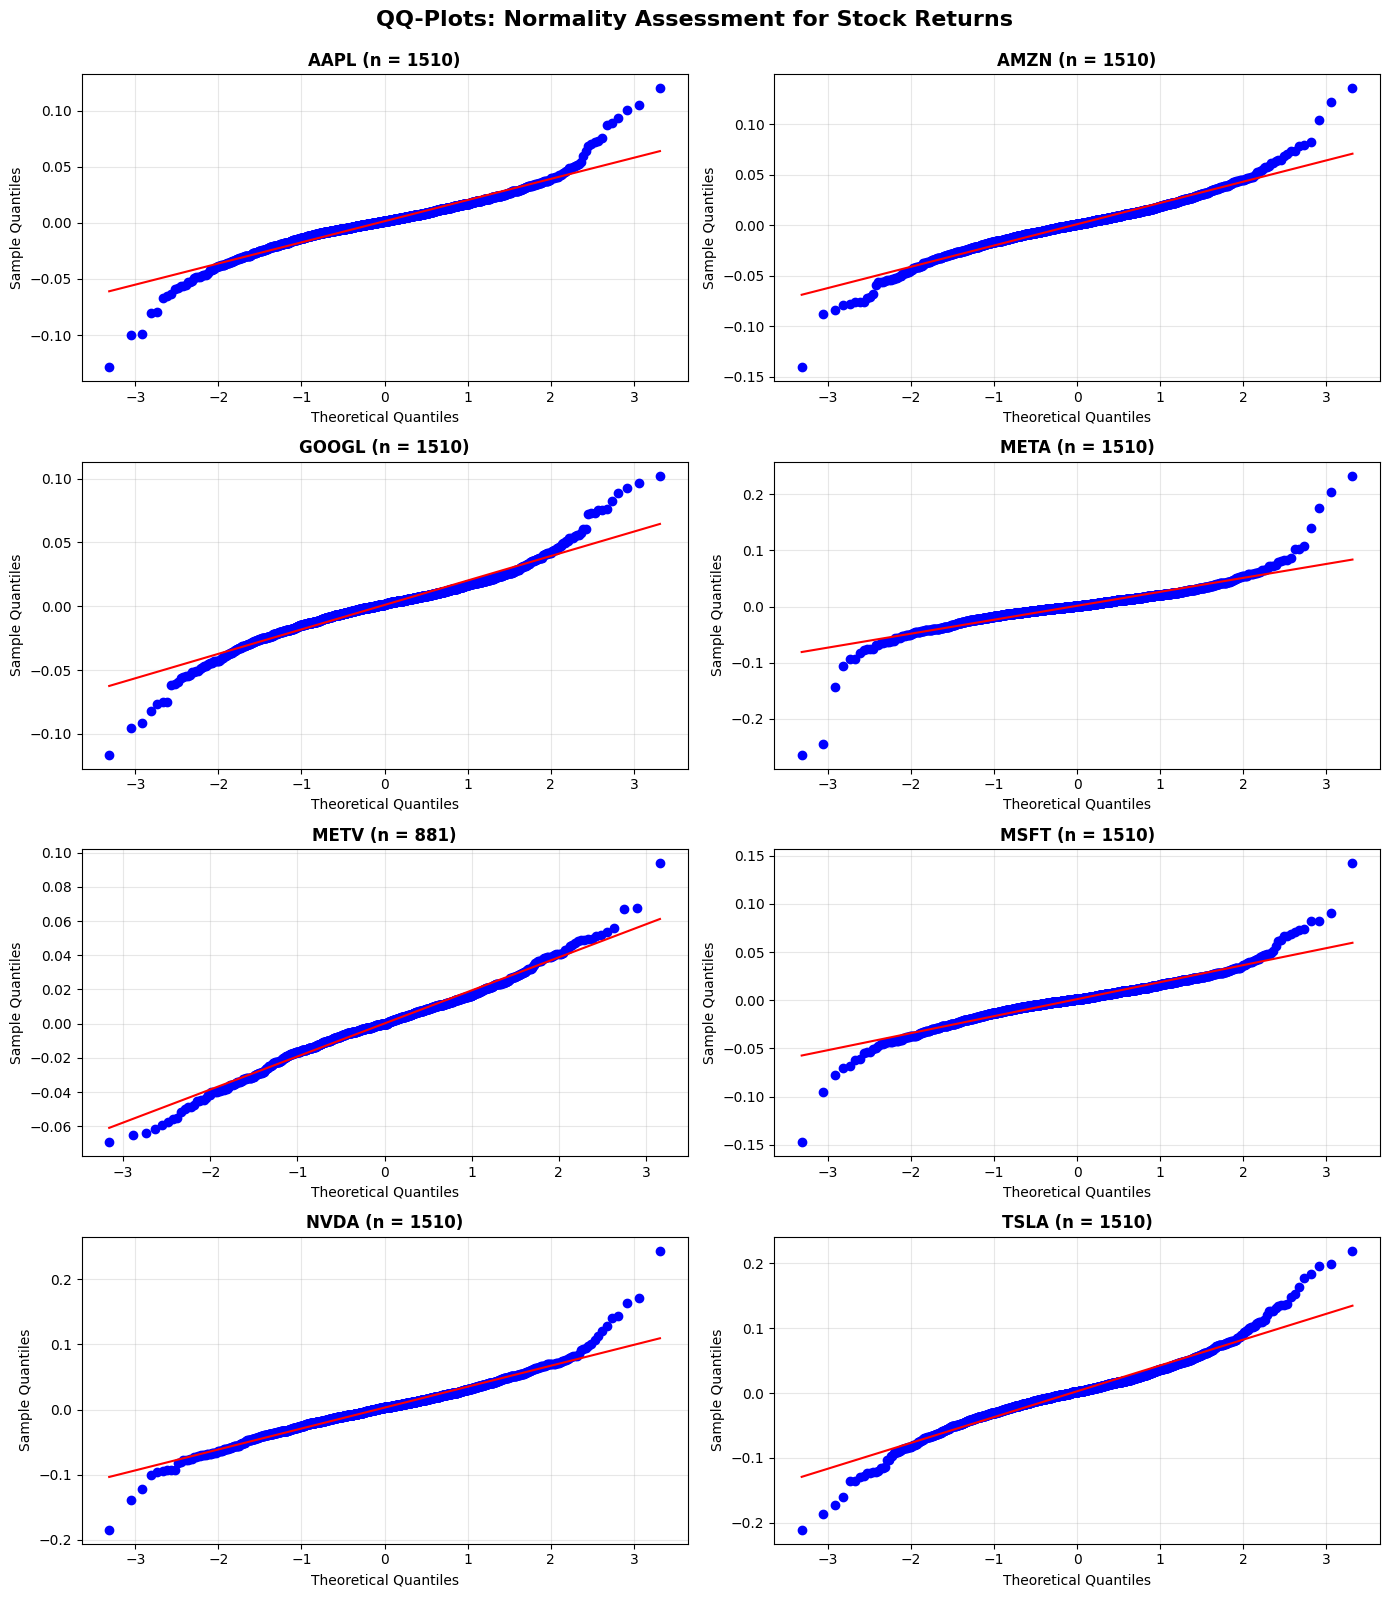

QQ-Plot Interpretation Guide

✓ Points on the 45° line    → Data follows normal distribution
✗ Points deviate from line  → Data departs from normality

Common patterns:
  • Heavy tails (fat tails) → Points curve away at extremes
  • Light tails             → Points curve toward line at extremes
  • Right skew              → Upper tail curves up
  • Left skew               → Lower tail curves down


In [51]:
# QQ-Plot

# Set up the figure with 4 rows x 2 columns (8 subplots)
fig, axes = plt.subplots(4, 2, figsize=(14, 16))
fig.suptitle('QQ-Plots: Normality Assessment for Stock Returns', fontsize=16, fontweight='bold', y=0.995)

# Flatten axes array for easier iteration
axes = axes.flatten()

# List of tickers
tickers = ['AAPL', 'AMZN', 'GOOGL', 'META', 'METV', 'MSFT', 'NVDA', 'TSLA']

# Generate QQ-plot for each ticker
for idx, ticker in enumerate(tickers):
    # Get returns data
    ticker_returns = returns[ticker].dropna()

    # Create QQ-plot
    stats.probplot(ticker_returns, dist="norm", plot=axes[idx])

    # Customize plot
    axes[idx].set_title(f'{ticker} (n = {len(ticker_returns)})', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlabel('Theoretical Quantiles', fontsize=10)
    axes[idx].set_ylabel('Sample Quantiles', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print interpretation guide
print("=" * 100)
print("QQ-Plot Interpretation Guide")
print("=" * 100)
print("\n✓ Points on the 45° line    → Data follows normal distribution")
print("✗ Points deviate from line  → Data departs from normality")
print("\nCommon patterns:")
print("  • Heavy tails (fat tails) → Points curve away at extremes")
print("  • Light tails             → Points curve toward line at extremes")
print("  • Right skew              → Upper tail curves up")
print("  • Left skew               → Lower tail curves down")
print("=" * 100)

In [52]:
# Comparison: Deviation

print("=" * 100)
print("Comparing Tests: Which Shows Strongest Deviation?")
print("=" * 100)
print("\nMethod: Smallest p-value indicates strongest evidence against normality\n")
print("-" * 100)

# Count wins for each test
test_wins = {
    'Shapiro-Wilk': 0,
    'D Agostino-Pearson K^2': 0,
    'Jarque-Bera': 0
}

# Compare for each ticker
tickers = ['AAPL', 'AMZN', 'GOOGL', 'META', 'METV', 'MSFT', 'NVDA', 'TSLA']

for ticker in tickers:
    result = normality_results[ticker]

    # Get p-values
    sw_pval = result['shapiro'][1]
    da_pval = result['dagostino'][1]
    jb_pval = result['jarque_bera'][1]

    # Find minimum p-value (strongest deviation)
    min_pval = min(sw_pval, da_pval, jb_pval)

    # Determine winner
    if sw_pval == min_pval:
        winner = 'Shapiro-Wilk'
    elif da_pval == min_pval:
        winner = 'D Agostino-Pearson K^2'
    else:
        winner = 'Jarque-Bera'

    # Count and print
    test_wins[winner] += 1
    print(f"{ticker:8s}: {winner} shows strongest deviation (p = {min_pval:.4e})")

# Final conclusion
print("\n" + "=" * 100)
print("Summary")
print("=" * 100)
print(f"\nOut of 8 tickers:")
print(f"  - Shapiro-Wilk:             {test_wins['Shapiro-Wilk']}/8 tickers")
print(f"  - D Agostino-Pearson K^2:   {test_wins['D Agostino-Pearson K^2']}/8 tickers")
print(f"  - Jarque-Bera:              {test_wins['Jarque-Bera']}/8 tickers")

# Determine overall winner
max_wins = max(test_wins.values())
overall_winner = [test for test, wins in test_wins.items() if wins == max_wins][0]

print(f"\n{'='*100}")
print(f"CONCLUSION: {overall_winner} shows the strongest deviation in {test_wins[overall_winner]}/8 cases.")
print(f"{'='*100}")

Comparing Tests: Which Shows Strongest Deviation?

Method: Smallest p-value indicates strongest evidence against normality

----------------------------------------------------------------------------------------------------
AAPL    : Jarque-Bera shows strongest deviation (p = 0.0000e+00)
AMZN    : Jarque-Bera shows strongest deviation (p = 1.3501e-255)
GOOGL   : Jarque-Bera shows strongest deviation (p = 9.2845e-233)
META    : Jarque-Bera shows strongest deviation (p = 0.0000e+00)
METV    : Jarque-Bera shows strongest deviation (p = 1.0861e-15)
MSFT    : Jarque-Bera shows strongest deviation (p = 0.0000e+00)
NVDA    : Jarque-Bera shows strongest deviation (p = 3.9422e-247)
TSLA    : Jarque-Bera shows strongest deviation (p = 1.3852e-169)

Summary

Out of 8 tickers:
  - Shapiro-Wilk:             0/8 tickers
  - D Agostino-Pearson K^2:   0/8 tickers
  - Jarque-Bera:              8/8 tickers

CONCLUSION: Jarque-Bera shows the strongest deviation in 8/8 cases.


# 📈 **PART 2**

## 2.1 Rolling Window Analysis

In [53]:
# Parameters
WINDOW_SIZE = 60  # 30 trading days (~1.5 months)

print("=" * 100)
print("Part 2.1: Rolling-Window Analysis")
print("=" * 100)
print(f"\nMethodology:")
print(f"  - Test: Jarque-Bera (most powerful from Part 1)")
print(f"  - Window size: {WINDOW_SIZE} trading days")
print(f"  - Rolling step: 1 day")
print("=" * 100)

# Store results
rolling_results = {}

# Perform rolling-window analysis for each ticker
tickers = ['AAPL', 'AMZN', 'GOOGL', 'META', 'METV', 'MSFT', 'NVDA', 'TSLA']

for ticker in tickers:
    print(f"\nProcessing {ticker}...")

    # Get returns for this ticker
    ticker_returns = returns[ticker].dropna()

    # Initialize storage
    dates = []
    p_values = []
    test_stats = []

    # Rolling window loop
    total_windows = len(ticker_returns) - WINDOW_SIZE + 1

    for i in range(total_windows):
        # Extract window
        window_data = ticker_returns.iloc[i:i+WINDOW_SIZE]

        # Window center date (middle of the window)
        center_idx = i + WINDOW_SIZE // 2
        window_date = ticker_returns.index[center_idx]

        # Perform Jarque-Bera test
        jb_stat, jb_pval, _, _ = jarque_bera(window_data)

        # Store results
        dates.append(window_date)
        p_values.append(jb_pval)
        test_stats.append(jb_stat)

    # Save to dictionary
    rolling_results[ticker] = {
        'dates': dates,
        'p_values': p_values,
        'test_stats': test_stats,
        'n_windows': total_windows
    }

    print(f"  Completed {total_windows} windows")

print("\n" + "=" * 100)
print("Rolling-window analysis completed!")
print("=" * 100)

# Summary statistics
print(f"\nSummary:")
for ticker in tickers:
    result = rolling_results[ticker]
    n_reject = sum(1 for p in result['p_values'] if p < 0.05)
    pct_reject = (n_reject / result['n_windows']) * 100
    print(f"{ticker:8s}: {n_reject:4d}/{result['n_windows']} windows reject normality ({pct_reject:.1f}%)")

Part 2.1: Rolling-Window Analysis

Methodology:
  - Test: Jarque-Bera (most powerful from Part 1)
  - Window size: 60 trading days
  - Rolling step: 1 day

Processing AAPL...
  Completed 1451 windows

Processing AMZN...
  Completed 1451 windows

Processing GOOGL...
  Completed 1451 windows

Processing META...
  Completed 1451 windows

Processing METV...
  Completed 822 windows

Processing MSFT...
  Completed 1451 windows

Processing NVDA...
  Completed 1451 windows

Processing TSLA...
  Completed 1451 windows

Rolling-window analysis completed!

Summary:
AAPL    :  678/1451 windows reject normality (46.7%)
AMZN    :  720/1451 windows reject normality (49.6%)
GOOGL   :  839/1451 windows reject normality (57.8%)
META    :  856/1451 windows reject normality (59.0%)
METV    :  112/822 windows reject normality (13.6%)
MSFT    :  364/1451 windows reject normality (25.1%)
NVDA    :  401/1451 windows reject normality (27.6%)
TSLA    :  651/1451 windows reject normality (44.9%)


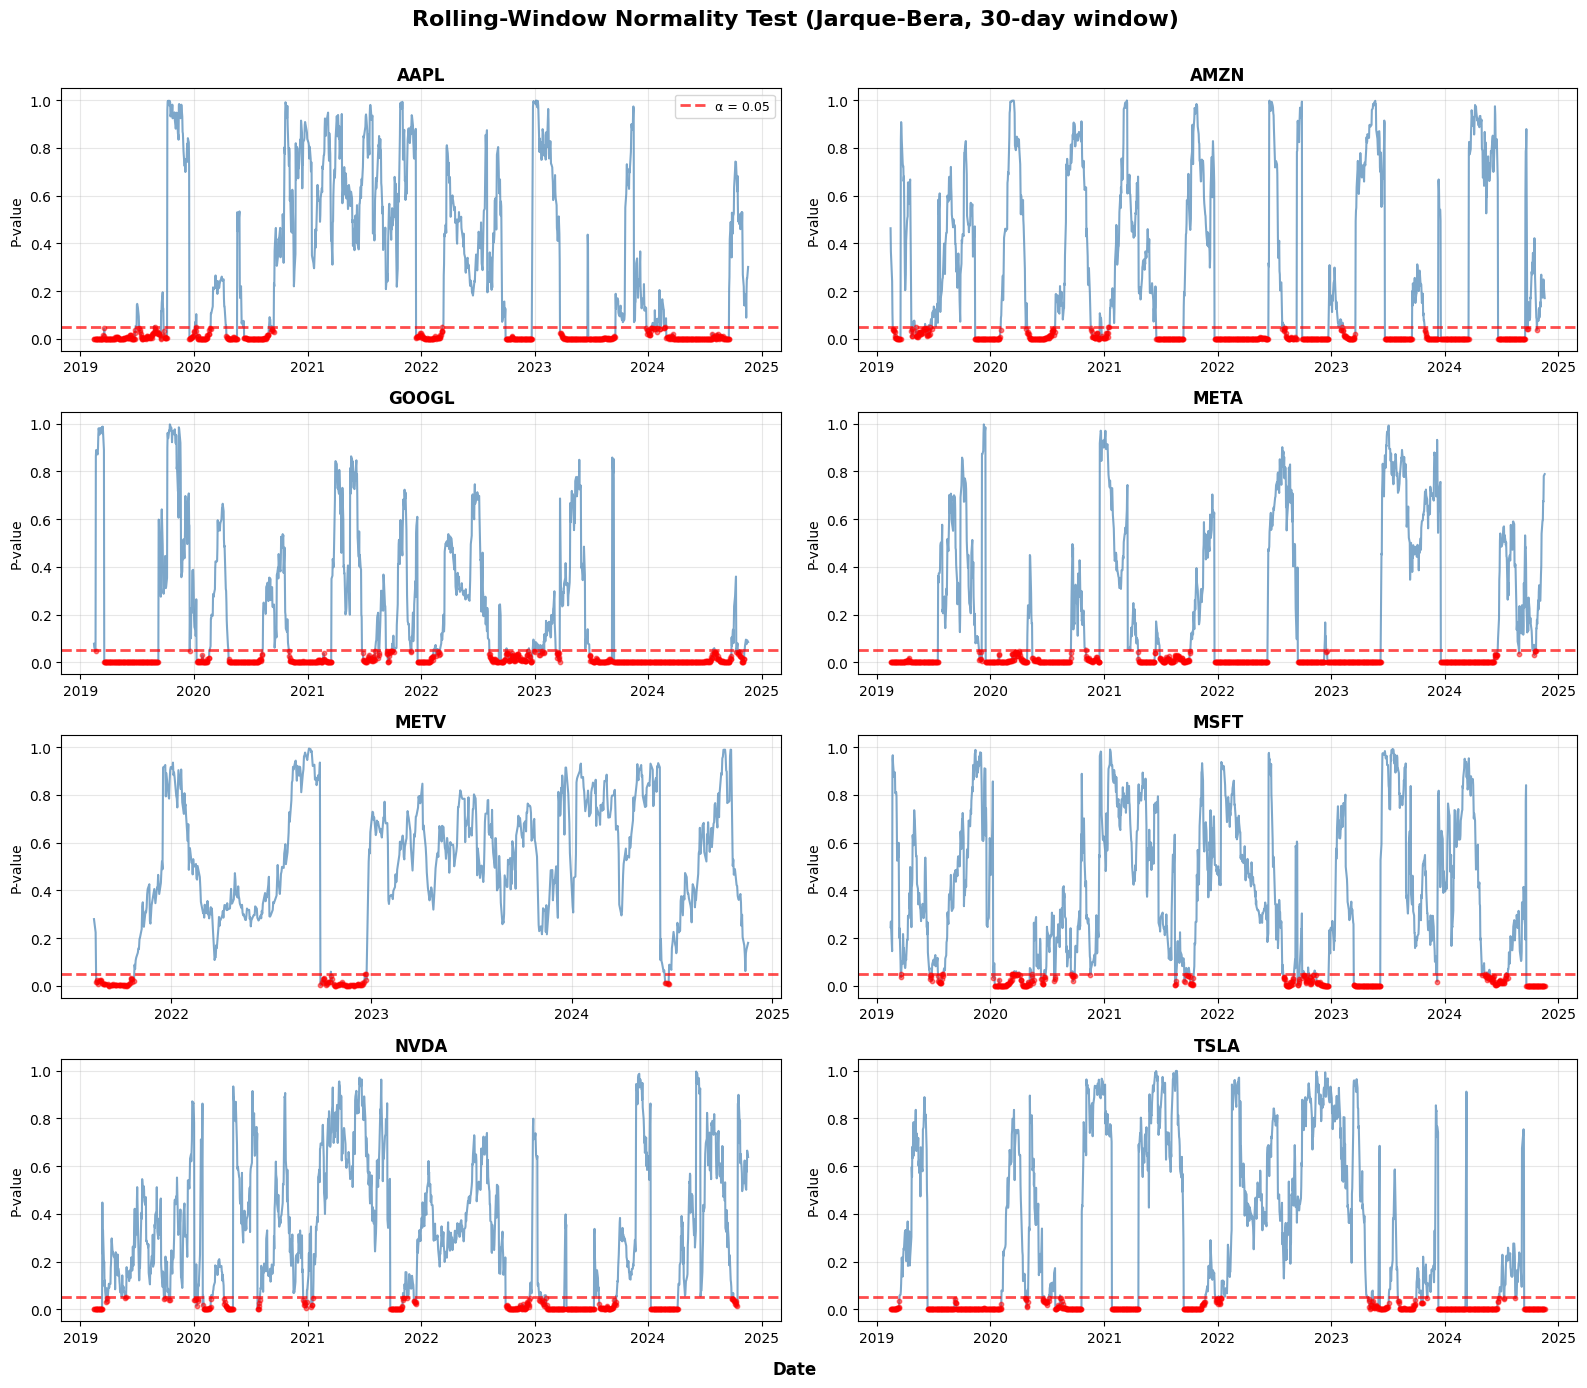


Interpretation Guide:
• Points BELOW red line (p < 0.05): Reject normality
• Points ABOVE red line (p ≥ 0.05): Fail to reject normality
• Clusters of red points: Periods of systematic non-normality


In [54]:
# Create figure with 8 subplots (4 rows x 2 columns)
fig, axes = plt.subplots(4, 2, figsize=(16, 14))
fig.suptitle('Rolling-Window Normality Test (Jarque-Bera, 30-day window)',
             fontsize=16, fontweight='bold', y=0.995)

# Flatten axes for easier iteration
axes = axes.flatten()

# Plot for each ticker
for idx, ticker in enumerate(tickers):
    result = rolling_results[ticker]

    ax = axes[idx]

    # Plot p-values over time
    ax.plot(result['dates'], result['p_values'],
            linewidth=1.5, color='steelblue', alpha=0.7)

    # Add horizontal line at α = 0.05
    ax.axhline(y=0.05, color='red', linestyle='--', linewidth=2,
               label='α = 0.05', alpha=0.7)

    # Shade regions where p < 0.05 (reject normality)
    reject_indices = [i for i, p in enumerate(result['p_values']) if p < 0.05]
    if reject_indices:
        dates_reject = [result['dates'][i] for i in reject_indices]
        p_reject = [result['p_values'][i] for i in reject_indices]
        ax.scatter(dates_reject, p_reject, color='red', s=10, alpha=0.5, zorder=5)

    # Formatting
    ax.set_title(f'{ticker}', fontsize=12, fontweight='bold')
    ax.set_ylabel('P-value', fontsize=10)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)

    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())

    # Legend only on first plot
    if idx == 0:
        ax.legend(loc='upper right', fontsize=9)

# Common x-label
fig.text(0.5, 0.02, 'Date', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

# Print interpretation
print("\n" + "=" * 100)
print("Interpretation Guide:")
print("=" * 100)
print("• Points BELOW red line (p < 0.05): Reject normality")
print("• Points ABOVE red line (p ≥ 0.05): Fail to reject normality")
print("• Clusters of red points: Periods of systematic non-normality")
print("=" * 100)

## 2.2 Simultaneity & Clustering Analysis

In [55]:
print("=" * 100)
print("Part 2.2: Simultaneity Across Tickers")
print("=" * 100)

# Step 1: Identify ticker groups and alignment
tickers_full = [t for t in tickers if rolling_results[t]['n_windows'] == 1451]
print(f"\nFull-period tickers (1451 windows): {', '.join(tickers_full)}")
print(f"Short-period ticker: METV ({rolling_results['METV']['n_windows']} windows)")

# Find where METV aligns with full-period tickers
metv_start_date = rolling_results['METV']['dates'][0]
aapl_dates = rolling_results['AAPL']['dates']
alignment_idx = next(i for i, d in enumerate(aapl_dates) if d >= metv_start_date)

print(f"\nMETV start date: {metv_start_date.strftime('%Y-%m-%d')}")
print(f"Aligns with window #{alignment_idx} of full-period tickers")

# Step 2: Period 1 - Before METV (7 tickers)
print("\n" + "=" * 100)
print(f"Period 1: Windows 0-{alignment_idx-1} (7 tickers, before METV)")
print("=" * 100)

simultaneity_period1 = []

for window_idx in range(alignment_idx):
    rejecting_tickers = []

    for ticker in tickers_full:
        if rolling_results[ticker]['p_values'][window_idx] < 0.05:
            rejecting_tickers.append(ticker)

    # Full simultaneity = 7/7
    if len(rejecting_tickers) == len(tickers_full):
        window_date = rolling_results['AAPL']['dates'][window_idx]
        simultaneity_period1.append({
            'window_idx': window_idx,
            'date': window_date,
            'tickers': rejecting_tickers
        })

print(f"\nWindows with full simultaneity (7/7): {len(simultaneity_period1)}")

if len(simultaneity_period1) > 0:
    print("\nWindows where ALL 7 tickers have p < 0.05:")
    for item in simultaneity_period1[:10]:
        tickers_str = ', '.join(item['tickers'])
        print(f"  Window #{item['window_idx']:4d} ({item['date'].strftime('%Y-%m-%d')}): {tickers_str}")
    if len(simultaneity_period1) > 10:
        print(f"  ... and {len(simultaneity_period1) - 10} more windows")

# Step 3: Period 2 - After METV (8 tickers)
print("\n" + "=" * 100)
print(f"Period 2: Windows {alignment_idx}-{1450} (8 tickers, including METV)")
print("=" * 100)

simultaneity_period2 = []
metv_n_windows = rolling_results['METV']['n_windows']

for metv_idx in range(metv_n_windows):
    full_idx = alignment_idx + metv_idx

    if full_idx >= 1451:
        break

    rejecting_tickers = []

    # Check full-period tickers
    for ticker in tickers_full:
        if rolling_results[ticker]['p_values'][full_idx] < 0.05:
            rejecting_tickers.append(ticker)

    # Check METV
    if rolling_results['METV']['p_values'][metv_idx] < 0.05:
        rejecting_tickers.append('METV')

    # Full simultaneity = 8/8
    if len(rejecting_tickers) == 8:
        window_date = rolling_results['AAPL']['dates'][full_idx]
        simultaneity_period2.append({
            'window_idx': full_idx,
            'date': window_date,
            'tickers': rejecting_tickers
        })

print(f"\nWindows with full simultaneity (8/8): {len(simultaneity_period2)}")

if len(simultaneity_period2) > 0:
    print("\nWindows where ALL 8 tickers have p < 0.05:")
    for item in simultaneity_period2[:10]:
        tickers_str = ', '.join(item['tickers'])
        print(f"  Window #{item['window_idx']:4d} ({item['date'].strftime('%Y-%m-%d')}): {tickers_str}")
    if len(simultaneity_period2) > 10:
        print(f"  ... and {len(simultaneity_period2) - 10} more windows")

# Step 4: Combined Summary
total_simultaneity = len(simultaneity_period1) + len(simultaneity_period2)

print("\n" + "=" * 100)
print("Summary Table")
print("=" * 100)
print(f"\nTotal windows with full simultaneity: {total_simultaneity}")
print(f"  - Period 1 (7/7 tickers): {len(simultaneity_period1)} windows")
print(f"  - Period 2 (8/8 tickers): {len(simultaneity_period2)} windows")

if alignment_idx > 0:
    pct1 = len(simultaneity_period1) / alignment_idx * 100
    print(f"\nPercentage of windows:")
    print(f"  - Period 1: {pct1:.1f}% ({len(simultaneity_period1)}/{alignment_idx})")
if metv_n_windows > 0:
    period2_total = min(metv_n_windows, 1451 - alignment_idx)
    pct2 = len(simultaneity_period2) / period2_total * 100
    print(f"  - Period 2: {pct2:.1f}% ({len(simultaneity_period2)}/{period2_total})")

# ==========================================
# Clustering Analysis
# ==========================================

print("\n" + "=" * 100)
print("Clustering Analysis")
print("=" * 100)

# Combine all simultaneity windows
all_sim_windows = []

for item in simultaneity_period1:
    all_sim_windows.append({
        'window_idx': item['window_idx'],
        'date': item['date'],
        'ratio': '7/7'
    })

for item in simultaneity_period2:
    all_sim_windows.append({
        'window_idx': item['window_idx'],
        'date': item['date'],
        'ratio': '8/8'
    })

all_sim_windows.sort(key=lambda x: x['window_idx'])

print(f"\nTotal simultaneity windows: {len(all_sim_windows)}")

if len(all_sim_windows) > 0:
    first_window = all_sim_windows[0]['window_idx']
    last_window = all_sim_windows[-1]['window_idx']
    first_date = all_sim_windows[0]['date']
    last_date = all_sim_windows[-1]['date']

    print(f"\nWindow range: #{first_window} to #{last_window}")
    print(f"Date range: {first_date.strftime('%Y-%m-%d')} to {last_date.strftime('%Y-%m-%d')}")
    print(f"\nAll simultaneity windows:")
    for item in all_sim_windows:
        print(f"  Window #{item['window_idx']:4d} ({item['date'].strftime('%Y-%m-%d')}): {item['ratio']}")

# ==========================================
# Answer Research Questions
# ==========================================

print("\n" + "=" * 100)
print("Answers to Research Questions")
print("=" * 100)

# Q1
print("\nQ1: Do extreme departures from normality occur at the same time for all stocks?")
print("-" * 100)

if total_simultaneity > 0:
    print(f"YES. We identified {total_simultaneity} windows where ALL available tickers")
    print(f"simultaneously rejected normality (p < 0.05):")
    if len(simultaneity_period1) > 0:
        print(f"  - {len(simultaneity_period1)} windows with 7/7 tickers (before METV listing)")
    if len(simultaneity_period2) > 0:
        print(f"  - {len(simultaneity_period2)} windows with 8/8 tickers (after METV listing)")
    print("\nThis indicates extreme departures are systematic market-wide phenomena,")
    print("not idiosyncratic to individual stocks.")
else:
    print("NO. No windows found with complete simultaneity.")
    print("Departures appear more stock-specific (idiosyncratic).")

# Q2
print("\n\nQ2: Are there 'clusters' of non-normality, or is it idiosyncratic?")
print("-" * 100)

if total_simultaneity == 0:
    print("IDIOSYNCRATIC. No systematic simultaneity observed.")
else:
    # Objective temporal concentration analysis
    first_window = all_sim_windows[0]['window_idx']
    last_window = all_sim_windows[-1]['window_idx']
    window_span = last_window - first_window + 1
    total_windows = 1451

    first_date = all_sim_windows[0]['date']
    last_date = all_sim_windows[-1]['date']
    date_span_days = (last_date - first_date).days
    total_days = (rolling_results['AAPL']['dates'][-1] - rolling_results['AAPL']['dates'][0]).days

    concentration_pct = window_span / total_windows * 100

    print(f"Temporal Concentration Analysis:")
    print(f"  - Simultaneity windows: {total_simultaneity}")
    print(f"  - Window range: #{first_window}-#{last_window} ({window_span} windows)")
    print(f"  - Concentration: {concentration_pct:.1f}% of total sample")
    print(f"  - Date range: {first_date.strftime('%Y-%m-%d')} to {last_date.strftime('%Y-%m-%d')} (~{date_span_days/30:.1f} months)")
    print(f"  - Total sample: {total_windows} windows (~{total_days/365:.1f} years)")

    # Objective classification based on concentration
    print(f"\nClassification:")
    if concentration_pct < 5:
        classification = "STRONG CLUSTERING"
        interpretation = "highly concentrated in a narrow time period"
    elif concentration_pct < 15:
        classification = "MODERATE CLUSTERING"
        interpretation = "concentrated but spans multiple distinct periods"
    elif concentration_pct < 30:
        classification = "WEAK CLUSTERING"
        interpretation = "somewhat dispersed across the sample"
    else:
        classification = "IDIOSYNCRATIC"
        interpretation = "widely dispersed, no clear clustering"

    print(f"  → {classification}")
    print(f"  → Simultaneity windows are {interpretation}")

    print(f"\nInterpretation:")
    if concentration_pct < 5:
        print(f"  Non-normality is NOT randomly distributed, but heavily concentrated")
        print(f"  during a specific crisis period. This demonstrates systematic risk")
        print(f"  clustering, where extreme events occur together in time rather than")
        print(f"  being spread across the sample.")
    elif concentration_pct < 15:
        print(f"  Non-normality shows clear temporal concentration, suggesting that")
        print(f"  extreme events tend to cluster during stress periods, though with")
        print(f"  some dispersion across multiple distinct episodes.")
    elif concentration_pct < 30:
        print(f"  Non-normality shows some temporal concentration, but with notable")
        print(f"  dispersion across the sample period, suggesting a mix of clustered")
        print(f"  stress periods and more isolated events.")
    else:
        print(f"  Non-normality is widely dispersed across the sample period,")
        print(f"  suggesting idiosyncratic or randomly distributed extreme events")
        print(f"  rather than systematic temporal clustering.")

print("\n" + "=" * 100)

Part 2.2: Simultaneity Across Tickers

Full-period tickers (1451 windows): AAPL, AMZN, GOOGL, META, MSFT, NVDA, TSLA
Short-period ticker: METV (822 windows)

METV start date: 2021-08-13
Aligns with window #629 of full-period tickers

Period 1: Windows 0-628 (7 tickers, before METV)

Windows with full simultaneity (7/7): 4

Windows where ALL 7 tickers have p < 0.05:
  Window # 228 (2020-01-10): AAPL, AMZN, GOOGL, META, MSFT, NVDA, TSLA
  Window # 241 (2020-01-30): AAPL, AMZN, GOOGL, META, MSFT, NVDA, TSLA
  Window # 243 (2020-02-03): AAPL, AMZN, GOOGL, META, MSFT, NVDA, TSLA
  Window # 300 (2020-04-24): AAPL, AMZN, GOOGL, META, MSFT, NVDA, TSLA

Period 2: Windows 629-1450 (8 tickers, including METV)

Windows with full simultaneity (8/8): 0

Summary Table

Total windows with full simultaneity: 4
  - Period 1 (7/7 tickers): 4 windows
  - Period 2 (8/8 tickers): 0 windows

Percentage of windows:
  - Period 1: 0.6% (4/629)
  - Period 2: 0.0% (0/822)

Clustering Analysis

Total simultaneity 

# 📈 **PART 3**

No need for Code

# 📈 **Regression**

In [56]:
# Data Preparation

print("=" * 100)
print("STEP 1: DATA PREPARATION FOR REGRESSION ANALYSIS")
print("=" * 100)

# Define 7 tickers (excluding METV)
reg_tickers = ['AAPL', 'MSFT', 'META', 'AMZN', 'TSLA', 'GOOGL', 'NVDA']

print(f"\n1. Computing daily returns for {len(reg_tickers)} tech tickers:")
print(f"   (Excluding METV as per assignment note)")

# Use existing returns
returns_reg = returns[reg_tickers].copy()

# Show that returns are computed for each ticker
for ticker in reg_tickers:
    mean_ret = returns_reg[ticker].mean()
    std_ret = returns_reg[ticker].std()
    print(f"   {ticker}: mean = {mean_ret:.6f}, std = {std_ret:.6f}")

print(f"\n✓ Daily returns calculated for {len(reg_tickers)} tickers")
print(f"  Total observations: {len(returns_reg)}")

# Construct Tech Index Proxy (average of 7 stocks, time-varying)
returns_reg['TECH_IDX'] = returns_reg[reg_tickers].mean(axis=1)

print(f"\n2. Tech Index Proxy (TECH_IDX) created")
print(f"   Formula: TECH_IDX_t = (1/{len(reg_tickers)}) × Σ(returns_t)")
print(f"   Note: Time-varying (different value at each date t)")

# Build regression dataframe
reg_data = returns_reg[['AAPL', 'MSFT', 'GOOGL', 'TECH_IDX']].copy()

print(f"\n3. Regression dataframe built")

print("\n" + "=" * 100)
print("DATA PREPARATION COMPLETE")
print("=" * 100)

# 3번 이후에 추가
print(f"\n3. Regression dataframe built")
print(f"   Columns: AAPL, MSFT, GOOGL, TECH_IDX")

# Show the actual table (first and last few rows)
print("\n" + "=" * 100)
print("REGRESSION DATAFRAME (First 10 rows)")
print("=" * 100)
print(reg_data.head(10))

print("\n" + "=" * 100)
print("REGRESSION DATAFRAME (Last 10 rows)")
print("=" * 100)
print(reg_data.tail(10))

print("\n" + "=" * 100)
print("SUMMARY STATISTICS")
print("=" * 100)
print(reg_data.describe())

STEP 1: DATA PREPARATION FOR REGRESSION ANALYSIS

1. Computing daily returns for 7 tech tickers:
   (Excluding METV as per assignment note)
   AAPL: mean = 0.001444, std = 0.019420
   MSFT: mean = 0.001149, std = 0.018261
   META: mean = 0.001357, std = 0.026787
   AMZN: mean = 0.000941, std = 0.021502
   TSLA: mean = 0.002746, std = 0.040646
   GOOGL: mean = 0.001048, std = 0.019652
   NVDA: mean = 0.002985, std = 0.032678

✓ Daily returns calculated for 7 tickers
  Total observations: 1510

2. Tech Index Proxy (TECH_IDX) created
   Formula: TECH_IDX_t = (1/7) × Σ(returns_t)
   Note: Time-varying (different value at each date t)

3. Regression dataframe built

DATA PREPARATION COMPLETE

3. Regression dataframe built
   Columns: AAPL, MSFT, GOOGL, TECH_IDX

REGRESSION DATAFRAME (First 10 rows)
TSYMBOL         AAPL      MSFT     GOOGL  TECH_IDX
date                                              
2019-01-02  0.001141 -0.004430  0.009302  0.002571
2019-01-03 -0.099607 -0.036788 -0.027696 -

In [57]:
# Regression 1 - Raw Returns

# Set pandas display options
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 10)

print("=" * 100)
print("STEP 2: REGRESSION 1 - RAW RETURNS")
print("=" * 100)

# Model specification
print("\nModel: AAPL_t = α + β₁·MSFT_t + β₂·GOOGL_t + ε_t")

# Prepare data
X_raw = reg_data[['MSFT', 'GOOGL']]
y_raw = reg_data['AAPL']

print(f"\nTotal observations: {len(y_raw)}")

# Add constant (intercept)
X_raw_const = sm.add_constant(X_raw)

# Fit OLS regression
model_raw = sm.OLS(y_raw, X_raw_const).fit()

# Display full regression results
print("\n" + "=" * 100)
print("REGRESSION RESULTS")
print("=" * 100)
print(model_raw.summary())

# Create prediction table
pred_table_raw = reg_data[['AAPL', 'MSFT', 'GOOGL']].copy()
pred_table_raw['Predicted_AAPL'] = model_raw.fittedvalues
pred_table_raw['Residual'] = model_raw.resid

print("\n" + "=" * 100)
print("PREDICTION TABLE (First 10 observations)")
print("=" * 100)
print(pred_table_raw.head(10).to_string())

print("\n" + "=" * 100)
print("PREDICTION TABLE (Last 10 observations)")
print("=" * 100)
print(pred_table_raw.tail(10).to_string())

# Calculate prediction accuracy metrics
mse_raw = np.mean(model_raw.resid ** 2)
rmse_raw = np.sqrt(mse_raw)
mae_raw = np.mean(np.abs(model_raw.resid))

print("\n" + "=" * 100)
print("PREDICTION ACCURACY METRICS")
print("=" * 100)
print(f"MSE (Mean Squared Error):       {mse_raw:.8f}")
print(f"RMSE (Root Mean Squared Error): {rmse_raw:.6f}")
print(f"MAE (Mean Absolute Error):      {mae_raw:.6f}")

# Store results for comparison
results_raw = {
    # Coefficients
    'alpha': model_raw.params['const'],
    'beta_MSFT': model_raw.params['MSFT'],
    'beta_GOOGL': model_raw.params['GOOGL'],

    # Precision metrics
    'se_alpha': model_raw.bse['const'],
    'se_MSFT': model_raw.bse['MSFT'],
    'se_GOOGL': model_raw.bse['GOOGL'],
    'pval_alpha': model_raw.pvalues['const'],
    'pval_MSFT': model_raw.pvalues['MSFT'],
    'pval_GOOGL': model_raw.pvalues['GOOGL'],
    't_alpha': model_raw.tvalues['const'],
    't_MSFT': model_raw.tvalues['MSFT'],
    't_GOOGL': model_raw.tvalues['GOOGL'],

    # Accuracy metrics
    'R_squared': model_raw.rsquared,
    'Adj_R_squared': model_raw.rsquared_adj,
    'MSE': mse_raw,
    'RMSE': rmse_raw,
    'MAE': mae_raw
}

print("\n" + "=" * 100)
print("REGRESSION 1 COMPLETE")
print("=" * 100)

STEP 2: REGRESSION 1 - RAW RETURNS

Model: AAPL_t = α + β₁·MSFT_t + β₂·GOOGL_t + ε_t

Total observations: 1510

REGRESSION RESULTS
                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     960.6
Date:                Mon, 27 Oct 2025   Prob (F-statistic):          1.11e-269
Time:                        15:37:43   Log-Likelihood:                 4430.0
No. Observations:                1510   AIC:                            -8854.
Df Residuals:                    1507   BIC:                            -8838.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


In [58]:
# Regression 2 - Demeaned (Excess) Returns

# Set pandas display options
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 10)

print("=" * 100)
print("STEP 3: REGRESSION 2 - DEMEANED (EXCESS) RETURNS")
print("=" * 100)

# Model specification
print("\nModel: (AAPL_t - TECH_IDX_t) = α + β₁·(MSFT_t - TECH_IDX_t) + β₂·(GOOGL_t - TECH_IDX_t) + ε_t")

# Calculate excess returns (demeaned)
reg_data['AAPL_excess'] = reg_data['AAPL'] - reg_data['TECH_IDX']
reg_data['MSFT_excess'] = reg_data['MSFT'] - reg_data['TECH_IDX']
reg_data['GOOGL_excess'] = reg_data['GOOGL'] - reg_data['TECH_IDX']

print("\n✓ Excess returns calculated by subtracting TECH_IDX from each stock")

# Show sample of excess returns
print("\n" + "=" * 100)
print("EXCESS RETURNS (First 10 observations)")
print("=" * 100)
print(reg_data[['AAPL_excess', 'MSFT_excess', 'GOOGL_excess']].head(10).to_string())

# Prepare data
X_demeaned = reg_data[['MSFT_excess', 'GOOGL_excess']]
y_demeaned = reg_data['AAPL_excess']

print(f"\nTotal observations: {len(y_demeaned)}")

# Add constant
X_demeaned_const = sm.add_constant(X_demeaned)

# Fit OLS regression
model_demeaned = sm.OLS(y_demeaned, X_demeaned_const).fit()

# Display full regression results
print("\n" + "=" * 100)
print("REGRESSION RESULTS")
print("=" * 100)
print(model_demeaned.summary())

# Create prediction table
pred_table_demeaned = reg_data[['AAPL_excess', 'MSFT_excess', 'GOOGL_excess']].copy()
pred_table_demeaned['Predicted_AAPL_excess'] = model_demeaned.fittedvalues
pred_table_demeaned['Residual'] = model_demeaned.resid

print("\n" + "=" * 100)
print("PREDICTION TABLE (First 10 observations)")
print("=" * 100)
print(pred_table_demeaned.head(10).to_string())

print("\n" + "=" * 100)
print("PREDICTION TABLE (Last 10 observations)")
print("=" * 100)
print(pred_table_demeaned.tail(10).to_string())

# Calculate prediction accuracy metrics
mse_demeaned = np.mean(model_demeaned.resid ** 2)
rmse_demeaned = np.sqrt(mse_demeaned)
mae_demeaned = np.mean(np.abs(model_demeaned.resid))

print("\n" + "=" * 100)
print("PREDICTION ACCURACY METRICS")
print("=" * 100)
print(f"MSE (Mean Squared Error):       {mse_demeaned:.8f}")
print(f"RMSE (Root Mean Squared Error): {rmse_demeaned:.6f}")
print(f"MAE (Mean Absolute Error):      {mae_demeaned:.6f}")

# Store results for comparison
results_demeaned = {
    # Coefficients
    'alpha': model_demeaned.params['const'],
    'beta_MSFT': model_demeaned.params['MSFT_excess'],
    'beta_GOOGL': model_demeaned.params['GOOGL_excess'],

    # Precision metrics
    'se_alpha': model_demeaned.bse['const'],
    'se_MSFT': model_demeaned.bse['MSFT_excess'],
    'se_GOOGL': model_demeaned.bse['GOOGL_excess'],
    'pval_alpha': model_demeaned.pvalues['const'],
    'pval_MSFT': model_demeaned.pvalues['MSFT_excess'],
    'pval_GOOGL': model_demeaned.pvalues['GOOGL_excess'],
    't_alpha': model_demeaned.tvalues['const'],
    't_MSFT': model_demeaned.tvalues['MSFT_excess'],
    't_GOOGL': model_demeaned.tvalues['GOOGL_excess'],

    # Accuracy metrics
    'R_squared': model_demeaned.rsquared,
    'Adj_R_squared': model_demeaned.rsquared_adj,
    'MSE': mse_demeaned,
    'RMSE': rmse_demeaned,
    'MAE': mae_demeaned
}

print("\n" + "=" * 100)
print("REGRESSION 2 COMPLETE")
print("=" * 100)

STEP 3: REGRESSION 2 - DEMEANED (EXCESS) RETURNS

Model: (AAPL_t - TECH_IDX_t) = α + β₁·(MSFT_t - TECH_IDX_t) + β₂·(GOOGL_t - TECH_IDX_t) + ε_t

✓ Excess returns calculated by subtracting TECH_IDX from each stock

EXCESS RETURNS (First 10 observations)
TSYMBOL     AAPL_excess  MSFT_excess  GOOGL_excess
date                                              
2019-01-02    -0.001430    -0.007001      0.006731
2019-01-03    -0.055284     0.007535      0.016627
2019-01-04    -0.008662    -0.004842     -0.000057
2019-01-07    -0.022145    -0.018644     -0.021913
2019-01-08     0.010430    -0.001382      0.000150
2019-01-09     0.006890     0.004208     -0.013519
2019-01-10    -0.001038    -0.010660     -0.006841
2019-01-11    -0.008153    -0.006057     -0.011646
2019-01-14    -0.005909     0.001832     -0.003047
2019-01-15    -0.003663     0.004875      0.009155

Total observations: 1510

REGRESSION RESULTS
                            OLS Regression Results                            
Dep. Varia

In [59]:
# Compare & Interpret

print("=" * 100)
print("STEP 4: COMPARISON OF TWO REGRESSION MODELS")
print("=" * 100)

# Create comparison dataframe
comparison_data = {
    'Metric': [
        'R²',
        'Adjusted R²',
        'MSE',
        'RMSE',
        'MAE',
        'SE(α)',
        'SE(β₁)',
        'SE(β₂)',
        'p-value(α)',
        'p-value(β₁)',
        'p-value(β₂)',
        't-stat(α)',
        't-stat(β₁)',
        't-stat(β₂)'
    ],
    'Raw Returns': [
        results_raw['R_squared'],
        results_raw['Adj_R_squared'],
        results_raw['MSE'],
        results_raw['RMSE'],
        results_raw['MAE'],
        results_raw['se_alpha'],
        results_raw['se_MSFT'],
        results_raw['se_GOOGL'],
        results_raw['pval_alpha'],
        results_raw['pval_MSFT'],
        results_raw['pval_GOOGL'],
        results_raw['t_alpha'],
        results_raw['t_MSFT'],
        results_raw['t_GOOGL']
    ],
    'Demeaned Returns': [
        results_demeaned['R_squared'],
        results_demeaned['Adj_R_squared'],
        results_demeaned['MSE'],
        results_demeaned['RMSE'],
        results_demeaned['MAE'],
        results_demeaned['se_alpha'],
        results_demeaned['se_MSFT'],
        results_demeaned['se_GOOGL'],
        results_demeaned['pval_alpha'],
        results_demeaned['pval_MSFT'],
        results_demeaned['pval_GOOGL'],
        results_demeaned['t_alpha'],
        results_demeaned['t_MSFT'],
        results_demeaned['t_GOOGL']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Determine winner for each metric
def determine_winner(metric, raw_val, dem_val):
    # Higher is better
    if metric in ['R²', 'Adjusted R²', 't-stat(α)', 't-stat(β₁)', 't-stat(β₂)']:
        if raw_val > dem_val:
            return 'Raw'
        elif dem_val > raw_val:
            return 'Demeaned'
        else:
            return 'Tie'
    # Lower is better
    elif metric in ['MSE', 'RMSE', 'MAE', 'SE(α)', 'SE(β₁)', 'SE(β₂)', 'p-value(α)', 'p-value(β₁)', 'p-value(β₂)']:
        if raw_val < dem_val:
            return 'Raw'
        elif dem_val < raw_val:
            return 'Demeaned'
        else:
            return 'Tie'
    return '-'

comparison_df['Winner'] = comparison_df.apply(
    lambda row: determine_winner(row['Metric'], row['Raw Returns'], row['Demeaned Returns']),
    axis=1
)

# Display comparison table
print("\n" + "=" * 100)
print("COMPARISON TABLE")
print("=" * 100)
print(comparison_df.to_string(index=False))

# Summary of winners
print("\n" + "=" * 100)
print("SUMMARY")
print("=" * 100)

raw_wins = (comparison_df['Winner'] == 'Raw').sum()
demeaned_wins = (comparison_df['Winner'] == 'Demeaned').sum()
ties = (comparison_df['Winner'] == 'Tie').sum()

print(f"\nRaw Returns model wins:      {raw_wins}/14 metrics")
print(f"Demeaned Returns model wins: {demeaned_wins}/14 metrics")
print(f"Ties:                        {ties}/14 metrics")

# Interpretation
print("\n" + "=" * 100)
print("INTERPRETATION")
print("=" * 100)

print("\n1. ACCURACY (Prediction Performance):")
print(f"   - R²: Raw = {results_raw['R_squared']:.4f}, Demeaned = {results_demeaned['R_squared']:.4f}")
print(f"     → Winner: {comparison_df[comparison_df['Metric']=='R²']['Winner'].values[0]}")
print(f"   - RMSE: Raw = {results_raw['RMSE']:.6f}, Demeaned = {results_demeaned['RMSE']:.6f}")
print(f"     → Winner: {comparison_df[comparison_df['Metric']=='RMSE']['Winner'].values[0]}")

print("\n2. PRECISION (Coefficient Reliability):")
print(f"   - Average SE: Raw = {np.mean([results_raw['se_MSFT'], results_raw['se_GOOGL']]):.6f}")
print(f"                 Demeaned = {np.mean([results_demeaned['se_MSFT'], results_demeaned['se_GOOGL']]):.6f}")

print("\n" + "=" * 100)
print("COMPARISON COMPLETE")
print("=" * 100)

STEP 4: COMPARISON OF TWO REGRESSION MODELS

COMPARISON TABLE
     Metric  Raw Returns  Demeaned Returns   Winner
         R² 5.603997e-01      8.657764e-02      Raw
Adjusted R² 5.598163e-01      8.536540e-02      Raw
        MSE 1.656860e-04      1.393778e-04 Demeaned
       RMSE 1.287191e-02      1.180584e-02 Demeaned
        MAE 9.140431e-03      8.564143e-03 Demeaned
      SE(α) 3.322524e-04      3.046744e-04 Demeaned
     SE(β₁) 2.684787e-02      2.981403e-02      Raw
     SE(β₂) 2.494652e-02      2.541512e-02      Raw
 p-value(α) 1.197450e-01      9.028679e-01      Raw
p-value(β₁) 1.434184e-99      1.959870e-27      Raw
p-value(β₂) 6.078248e-17      3.362352e-01      Raw
  t-stat(α) 1.556728e+00     -1.220598e-01      Raw
 t-stat(β₁) 2.286377e+01      1.106896e+01      Raw
 t-stat(β₂) 8.463130e+00      9.619378e-01      Raw

SUMMARY

Raw Returns model wins:      10/14 metrics
Demeaned Returns model wins: 4/14 metrics
Ties:                        0/14 metrics

INTERPRETATION

1. A